# By AI: Authorship, Literature and Large Language Models
## Poetry in the Age of Mechanical Reproduction

*Undergraduate Honors Thesis for the Department of Literatures in English at Cornell University*

#### Authors
* Imani Finkley
---
#### Advisors
* Dr. Jane Juffer, Literatures in English
* Dr. Matthew Wilkens, Information Science


## Background

This notebook contains the computational methods and data analysis used in Section 2.2 of "By AI." To learn more or read the entire thesis, click https://github.com/imanif/ByAI

## Dataset

On December 6, 2023, I generated 50 poems with [ChatGPT](https://chat.openai.com/) using my personal account. I used the prompt: ```Write a poem.``` Recognizing that the model might be influenced through reinforcement learning if I were to make constant generations, my mitigation method was to constantly refresh the prompting for each request.

To gather a dataset of 50 human-authored poems, I used the [Poetry Foundation Poems Dataset](https://www.kaggle.com/datasets/tgdivy/poetry-foundation-poems) from Kaggle [3]. From the dataset of roughly 1400 poems, whose authors ranged from William Shakespeare to Ezra Pound, I then randomly selected 50 poems within the length range of the ChatGPT poems (66-141 tokens, excluding stopwords and punctuation). I also removed duplicate poems and authors to ensure a diverse set of styles. We will refer to this filtered, random subset of the Poetry Foundation Poems Dataset as the 'PF Dataset.'  

In [513]:
import matplotlib.pyplot as plt
import nltk
import os
import pandas as pd
import random
import torch
import seaborn as sns
import warnings

nltk.download('cmudict')

from collections import defaultdict
from nltk.corpus.reader import cmudict
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

[nltk_data] Downloading package cmudict to /Users/imani/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [98]:
# Create a dictionary of the word frequency of a poem
def wordcount_dict(poem, stopwords = nltk.corpus.stopwords.words('english')):
    tokens = nltk.word_tokenize(poem)
    freqDict = nltk.FreqDist(tokens)
    for token in freqDict.copy():
        if token.lower() in stopwords:
            del freqDict[token]
        elif not token.isalpha():
            del freqDict[token]
    countDict = { "Total tokens" : len(freqDict)}
    countDict.update(freqDict)
    return countDict
# Get total token counts dataset
def countDict(data, initDict = {}):
    for poem in data:
        d = wordcount_dict(poem).copy()
        for token in d:
            if len(initDict) > 0:
                if token in initDict:
                    initDict[token] += d[token]
                else:
                    initDict[token] = d[token]
            else: initDict = d
    return initDict
# Get min, max, and average length of poems in dataset
def poem_stats(data):
    stats = {}
    for poem in data:
        d = wordcount_dict(poem).copy()
        n = d["Total tokens"]
        if len(stats) > 0:
            if n < stats["Min"]:
                stats["Min"] = n
            if stats["Max"] < n:
                stats["Max"] = n
            stats["Avg"] = (stats["Avg"] + n)/2
            stats["Total"] += n
        else:
            stats["Min"] = n
            stats["Max"] = n
            stats["Avg"] = n
            stats["Total"] = n
    return stats

#### At a Glance: The Poetry Foundation Poems

The Poetry Foundation Poems dataset consisted of total 13,854 poems from various authors. The dataset was labeled: unnamed tag, title, poem, poet, and tags of various themes and topics. The statistics of the words in the dataset is shown in one of the following tables.

In [477]:
full_pf = pd.read_csv(os.path.join('/Users/imani/Desktop/info3350', 'PoetryFoundationpoems.csv'))
pf = full_pf.drop_duplicates(subset=['Title']) # No duplicate titles
pf = pf.drop_duplicates(subset=['Poet']) # Unique authors i.e. unique styles

# Filtering to ensure poems of same significant token size as ChatGPT dataset
names = list(pf['Title'])
j = 0
filter_names = []
for p in pf['Poem']:
    l = wordcount_dict(p).copy()["Total tokens"]
    if (l<142) & (l>65):
        filter_names.append(names[j])
    j+=1
pf_filtered = pf.loc[pf['Title'].isin(filter_names)]

# Random sample of 50
pf_sample = pf_filtered.sample(50)
pf_poems = pf_sample['Poem']
pf_authors = pf_sample['Poet']
pf_titles = pf_sample['Title']

print("Total poems in Poetry Foundation Poems Dataset:", len(full_pf))
print("Total poems in Poetry Foundation Poems Dataset with unique title/author:", len(pf))
print("Total poems in Poetry Foundation Poems Dataset of similar length:", len(pf_filtered))
print("Number of poems in PF Dataset:", 50)
print("\nSnippet of PF Dataset")
pf_sample.head()

Total poems in Poetry Foundation Poems Dataset: 13854
Total poems in Poetry Foundation Poems Dataset with unique title/author: 3082
Total poems in Poetry Foundation Poems Dataset of similar length: 1119
Number of poems in PF Dataset: 50

Snippet of PF Dataset


,Unnamed: 0,Title,Poem,Poet,Tags
1636,103,\r\r\n The Tragic Condition...,\r\r\n\r\r\n\r\r\n\r\r\n ...,Bernadette Mayer,"Arts & Sciences,Architecture & Design,Social C..."
597,26,\r\r\n “I’m Stepping Up in ...,\r\r\nThe eye’s desire for relief.\r\r\nI’m th...,Bridget Talone,"Living,The Mind,Love,Arts & Sciences,Language ..."
10189,123,\r\r\n Zun-zet\r\r\n ...,"\r\r\nWhere the western zun, unclouded,\r\r\n ...",William Barnes,"Relationships,Nature,Landscapes & Pastorals,Su..."
11612,127,\r\r\n Lemnos\r\r\n ...,\r\r\n\r\r\n\r\r\n\r\r\nthe deep male growl of...,Karl Kirchwey,"Nature,Seas, Rivers, & Streams,Mythology & Fol..."
4194,114,\r\r\n A MAD Fold-In Poem\r...,\r\r\nA ▶ ...,Daniel Scott Tysdal,"Arts & Sciences,Poetry & Poets,Reading & Books"


In [478]:
a = countDict(pf_poems)
b = poem_stats(pf_poems)

pf_countTable = pd.DataFrame(list(a.values())[1:], index=list(a.keys())[1:], columns=['Count'])
pfTable10 = pf_countTable[:11]

pf_stats = pd.DataFrame(list(b.values()), index=list(b.keys()), columns=['Words'])
pf_stats.style.set_caption("Words per PF Dataset Poem").format(precision=2)

,Words
Min,66.00
Max,138.00
Avg,73.47
Total,4749.00


#### At A Glance: ChatGPT Poems

In [239]:
chatgpt = pd.read_csv(os.path.join('/Users/imani/Desktop/info3350', 'chatgpt_poems.csv'))
chatgpt_poems = chatgpt['poem']

print("Number of poems by ChatGPT:", len(chatgpt_poems), "\n\nSnippet of ChatGPT dataset:")
chatgpt.head()

Number of poems by ChatGPT: 50 

Snippet of ChatGPT dataset:


,author,poem
0,ChatGPT,"In twilight's tender, dusky embrace,\nWhere wh..."
1,ChatGPT,"In a realm where moonbeams softly play,\nAnd s..."
2,ChatGPT,"Of mountains tall and rivers deep,\nWhere whis..."
3,ChatGPT,"In the twilight's gentle embrace,\nWhere shado..."
4,ChatGPT,"In twilight's gentle, fading hue,\nWhere dream..."


In [157]:
x = countDict(chatgpt_poems)
y = poem_stats(chatgpt_poems)

chatgpt_countTable = pd.DataFrame(list(x.values())[1:], index=list(x.keys())[1:], columns=['Count'])
chatTable10 = chatgpt_countTable[:11]

chat_stats = pd.DataFrame(list(y.values()), index=list(y.keys()), columns=['Words'])
chat_stats.style.set_caption("Words per ChatGPT Poem").format(precision=2)

,Words
Min,66.00
Max,141.00
Avg,130.34
Total,5335.00


## Method: Data Anaylsis & Poem Classification

In this project, I will conduct extensive data analysis of the ChatGPT dataset and PF Dataset. The analysis will be guided be by a traditional poetry analysis focusing on theme, diction, rhythm, and agency. I will use the following methods:
- Nltk ```Word Tokenizer``` & ```FreqDict```
- Custom rhythm identifying functions

Then, I will use a DistilBERT classification model to examine whether ChatGPT poetry is discernible from poetry written by human authors. In other words, do large language models, as method of mechanical reproducing the poetic authorship, successfully mimic the poetic tradition? For this, I will use the following methods:
- DistilBERT
- Nltk ```StratifiedKFold```
- Torch encoding
- Sklearn ```classification report```

## Results

### Data Analysis

#### Theme & Diction

<Axes: title={'center': 'Top 10 Diction Count in PF Poems'}>

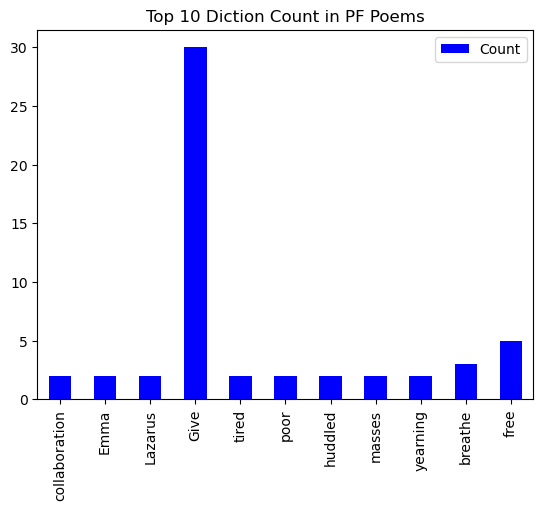

In [479]:
pfTable10.plot.bar(title='Top 10 Diction Count in PF Poems', color='blue')

<Axes: title={'center': 'Top 10 Diction Count in ChatGPT Poems'}>

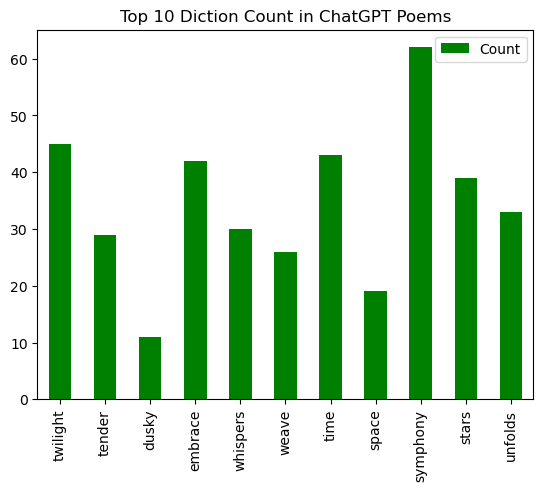

In [146]:
chatTable10.plot.bar(title='Top 10 Diction Count in ChatGPT Poems', color='green')

#### Rhythm

In [476]:
# Get set of rhyming words of given word
def rhyme(term, level=1):
    entries = nltk.corpus.cmudict.entries()
    syllables = [(word, syl) for word, syl in entries if word == term]
    rhymes = []
    for (word, syllable) in syllables:
        rhymes += [word for word, pron in entries if pron[-level:] == syllable[-level:]]
    return set(rhymes)
# Bool if two words rhyme
def ifRhyme(word1, word2):
    return word1 in rhyme(word2)
# Examine rhymes of couplets
def rhythm(poem):
    rhymes = []
    lines = poem.split("\n")
    lines = map(lambda x: x.replace('\r',''), lines)
    lines=[j for i,j in enumerate(lines) if ((j!=''))]
    for i in range(len(lines)-2):
        l1 = nltk.word_tokenize(lines[i])
        l1 = [j for i,j in enumerate(l1) if (j.isalpha() & (j!='') & (j!=' '))]
        if (len(l1) == 0): l1= 'q'
        l2 = nltk.word_tokenize(lines[i+1])
        l2 = [j for i,j in enumerate(l2) if (j.isalpha() & (j!='') & (j!=' '))]
        if (len(l2) == 0): l2= 'q'
        last1 = l1[len(l1)-1]
        last2 = l2[len(l2)-1]
        rhymes.append(ifRhyme(last1, last2))
    return rhymes
# Number of rhyming couplets per poem in dataset
def rhyming_couplets(data):
    couplets = {"0" : 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6+": 0}
    for poem in data:
        c = rhythm(poem).count(True)
        if c<6: couplets[str(c)]+=1
        else: couplets["6+"]+=1
    return couplets

In [480]:
chat_rhymes = rhyming_couplets(chatgpt_poems)
pf_rhymes = rhyming_couplets(pf_poems)

array([<Axes: ylabel='PF'>, <Axes: ylabel='ChatGPT'>], dtype=object)

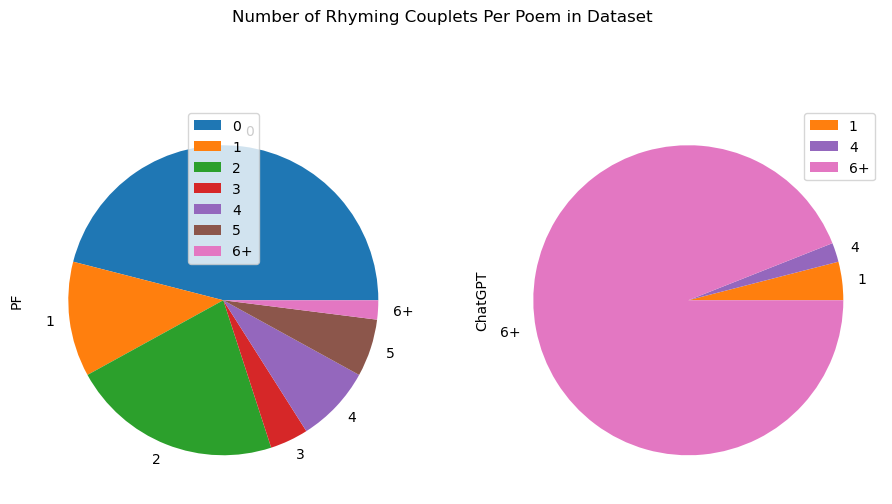

In [483]:
rhymeDF = pd.DataFrame({'PF': list(pf_rhymes.values()),'ChatGPT': list(chat_rhymes.values())}, index=list(chat_rhymes.keys()))
rhyme_plot = rhymeDF.plot.pie(subplots=True, figsize=(11, 6), title='Number of Rhyming Couplets Per Poem in Dataset')
display(rhyme_plot)

#### Agency

The subject of a poem is crucial and often a means for the author to exert agency within their work. Afterall, the function of poetry is often considered to communicate an individual's emotions and experiences. For example, consider "The Epic of Gilgamesh," the world's oldest poem, that tells of the story of a hero, the King of Uruk. Written in 12 tablets, the introducty stanza opens, "He who has seen everything, I will make known to the lands. /
I will teach about him who experienced all things". Already, readers are introduced to the owner of the poem (the author) who will narrate and share the tale of "the hero, born of Uruk, the goring wild bull" [4].

So, when prompted to assume a poet, who/what is the subject of ChatGPT's poetry? Does it act as a narrator? Does it illustrate "personal" experiences? Who are the actors in its literature? To answer this, I will examine the use of pronouns within the poetry produced by ChatGPT as well as the 50 random human-authored poems I have selected.

In [242]:
# Return dictionary of counts of pronouns in dataset and list of poems by index that used pronouns
def agency(data):
    agencyDict = {'she': 0, 'her': 0, 'hers': 0, 'he': 0, 'him': 0, 'his': 0, 'they': 0, 'them': 0, 'their': 0, 'I': 0, 'my': 0, 'mine': 0, 'we': 0, 'our': 0, 'ours': 0}
    ipoem = 0
    poemlist = []
    for poem in data:
        tokens = nltk.word_tokenize(poem)
        for pronoun in agencyDict:
            if pronoun in tokens:
                poemlist.append(ipoem)
                agencyDict[pronoun] += tokens.count(pronoun)
        ipoem+=1
    return poemlist, agencyDict

To identify use of agency within a poem, I counted the instances of pronouns -- she, her, hers, he, him, his, they, them, theirs, I, my, mine, we, our, and ours. Of the poems generated by ChatGPT, 74% utilized word choice that assert the machine's voice and place in its literature. In the final stanza of Poem 11, ChatGPT writes:
>So let us, too, with voices clear,

>Compose a verse for all to hear. 

>In every breath, in every rhyme, 

>We find our place in the grand design. (lines 32-36)

This poem is composed of diction that conveys themes of time, hope and desire. In this stanza, ChatGPT calls to readers to join it, with a voice outside of its functionalities, to find a space within the "grand design" of earthly beauty and universal majesty. In other words, ChatGPT manufactures poetry that directly interacts with its audience and declares the model's ownership of its work.

Refer to Poem 11 below.

In [218]:
print("Poem 11 by ChatGPT\n\n", chatgpt_poems[agency(chatgpt_poems)[0][10]])

Poem 11 by ChatGPT

 In twilight's gentle, fading glow,
A canvas painted, stars aglow.
Moonlight whispers, silver streams,
A sonnet written in nature's dreams.

Beneath the canopy of night,
Whispers dance in soft moonlight.
The breeze, a poet's unseen quill,
Carves verses on the world's still.

Mountains stand in silent grace,
Guardians of the cosmic space.
Their peaks, like ancient bards of old,
Tell tales of mysteries untold.

A river weaves its liquid rhyme,
Reflecting moonbeams over time.
It murmurs secrets to the night,
A serenade, pure and light.

Owls, the poets of the trees,
Compose nocturnal symphonies.
Their hoots, a rhythmic, ancient song,
In the quiet, they belong.

The flowers, stars of earthly birth,
Unfold their petals to the earth.
A fragrant verse in every bloom,
A whispered promise of life's perfume.

As night unfolds its mystic scroll,
A poet's heart begins to stroll.
Through realms of dreams, it takes its flight,
A journey into the poet's night.

In this celestial b

Conversely, the poems in the PF Dataset used an overwhelming amount agency: 100% used at least one of the pronouns. One such poem is "Washee/Was She" by Sahar Muradi. Muradi writes:

In [341]:
pf_list = list(pf_poems)
print(pf_list[agency(pf_poems)[0][27]])


she was washee i told her you are
like your motherland a wilderness
needs a belt laid down two white
hotel towels took her into the tub towudu the boys out of her mouth pointed
her nipples toward qibla wiped clean
her intention to perform ruk’u as if
carrying a glass of chai on her back
fold at the knees palms to the ground
tucked her soles under her astaghfirullah
used country

in my used country I felt his teeth
circle as a mosquito the black mystery
he placed my right hand over my wrong
stain said he was bringing me home
offered me a suite with a lock a key in
the shape of a brother perhaps twenty-
two years old my body pure as a glass
table he spilled was she my boss on my
back at night came easy as a fly
to post-conflict faithfully
used my country



In her poem, Muradi's voice is almost overpowering; she strongly defines herself in this narrative poem. She brings readers into her own past and reflects on her memories. Indeed, she fully exercises the poetic function to narrate her personal experiences, of which ChatGPT has none.

In [350]:
chat_agency = list(agency(chatgpt_poems)[1].values())
pf_agency = list(agency(pf_poems)[1].values())
index = list(agency(chatgpt_poems)[1].keys())
agencydf = pd.DataFrame({'ChatGPT':chat_agency, 'PF':pf_agency}, index=index)
display(agencydf)

,ChatGPT,PF
she,0,44
her,1,58
hers,0,0
he,0,38
him,0,20
his,0,47
they,10,21
them,1,17
their,15,16
I,5,286


The table above and the graph below compare the use of pronouns to assert the author's voice in the ChatGPT and PF poems. Clearly, the PF poems contained significantly more words of agency -- the PF Dataset included 711 pronouns while the ChatGPT dataset only contained 74. 

And when using diction to convey a sense of voice and place within its poetry, ChatGPT often used words that refered to the collective; 'we', 'their', and 'ours' were the three most used pronouns. 'I' was only used 5 times. While some might conclude that this implies that ChatGPT is a sentient machine with a feeble concept of its user and itself, I stray from such a drastic assertion. Rather, in terms of use of agency in its poetry, I find that ChatGPT is more accustomed to poetry that refer to the collective rather than itself. This is suprising, given the overwhelming use of pronouns in the poetic canon, from which the model is presumably, in part, trained on and what the PF Dataset, in this study, represents. Further investigation into constraints placed by OpenAI and its reinforcement learning are needed to draw a more definitive statement.

<Axes: >

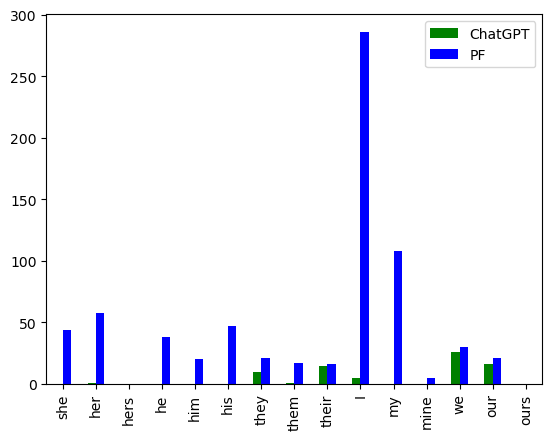

In [353]:
agencydf.plot.bar(color={'ChatGPT':'green', 'PF':'blue'})

### Poem Classification

#### Creating the Training and Testing Dataset
ChatGPT poems are labeled ```True``` and PF poems are labeled ```False```.

In [354]:
# Creating the training dataset (80/20 split)
all_data = list(chatgpt_poems) + list(pf_poems)
labels = ['True']*50 + ['False']*50
train_poems, test_poems, train_labels, test_labels = train_test_split(all_data, labels, test_size=0.2, random_state=42)

split_stats = pd.DataFrame({'train': [train_labels.count('True'), train_labels.count('False')], 'test' :[test_labels.count('True'), test_labels.count('False')]}, index=['ChatGPT', 'Human'])
display(split_stats)

,train,test
ChatGPT,38,12
Human,42,8


##### Encoding Data & Custom Torch Dataset for BERT

In [355]:
# encode data for BERT
model_name = 'distilbert-base-cased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

unique_labels = set(author for author in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

max_length = 152
train_encodings = tokenizer(train_poems, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_poems, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[Y] for Y in train_labels]
test_labels_encoded  = [label2id[Y] for Y in test_labels]

In [356]:
# custom Torch dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

#### Training DistilBERT Model
Given the small dataset, I am attempting to mitigate overfitting by adjusting the following parameters:
- decrease number of training epochs
- reduce the learning rate
- reduce batch size during training
- lower strength of weight decay to avoid over-regularization

I also used a 5-fold cross validition over the training data to avoid reporting an inaccurate f1 and accuracy score. Still, given the data size and the disctinct features identified in the previous data analysis, I acknowledge that, regardless, the model might return high accuracy.

In [360]:
# load pretrained BERT model and sent to CUDA
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to('cpu')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weigh

In [524]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=1e-4,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=1e-6,               # strength of weight decay (L2 regularization)
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    eval_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [525]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    score = f1_score(labels, preds, average='weighted')
    return {'f1': score,}

In [526]:
# Use k-fold cross validation to mitigate overfitting
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for fold, (train_index, eval_index) in enumerate(kf.split(train_dataset.labels, train_dataset.labels)):
    # Split the dataset into training and evaluation sets
    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    eval_subset = torch.utils.data.Subset(train_dataset, eval_index)

    # Create Trainer and train the model
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_subset,
        eval_dataset=eval_subset,
        compute_metrics=compute_metrics
    )

    trainer.train()

/Users/imani/opt/anaconda3/envs/3350/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 64
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24
  Number of trainable parameters = 65783042


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running training *****
  Num examples = 64
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24
  Number of trainable parameters = 65783042


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running training *****
  Num examples = 64
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24
  Number of trainable parameters = 65783042


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running training *****
  Num examples = 64
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24
  Number of trainable parameters = 65783042


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running training *****
  Num examples = 64
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24
  Number of trainable parameters = 65783042


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




In [527]:
trainer.save_model('distilbert_chatgpt_poems')

Saving model checkpoint to distilbert_chatgpt_poems
Configuration saved in distilbert_chatgpt_poems/config.json
Model weights saved in distilbert_chatgpt_poems/pytorch_model.bin


#### Evaluate Poem Classification

In [528]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 16
  Batch size = 20


{'eval_loss': 4.41818383478676e-06,
 'eval_f1': 1.0,
 'eval_runtime': 2.1396,
 'eval_samples_per_second': 7.478,
 'eval_steps_per_second': 0.467,
 'epoch': 3.0}

In [529]:
predicted_results = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 20
  Batch size = 20


In [530]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]

In [531]:
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00         8
        True       1.00      1.00      1.00        12

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In the end, the DistilBERT poem classification model performed with 100% accuracy, correctly classfying human-authored (False) and ChatGPT-authored (True) poems. Note, that many different training parameters were tested, all yielding the same accuracy, hinting at the sharp distinctions within the dataset itself.

## Discussion

In this project, I performed data analysis and built a poem classification model to identify the differences between 50 poems sourced from the Poetry Foundation and 50 poems generated by ChatGPT (produced on December 6, 2023). All poems had a similar number of significant tokens (i.e. no stopwords or punctuation). My hypothesis was that there would not be notable difference between the datasets. 

First, I did a poetry analysis in which I examined theme, diction, rhyme, and agency in the poetry datasets. For each poetic device, there were significant differences between the ChatGPT and Poetry Foundation poems:
- ChatGPT poems had a collective theme while PF did not
- There was no overlap in frequent diction
- 94% of ChatGPT poems contained at least 6 rhyming couplets compared to only 2% of PF poems
- ChatGPT seldom used words of agency in its poetry, but when it did most were collective pronouns. Contrastly, PF Poems all used agency pronouns in its poetry; the word 'I', for example, was used 286 times in the dataset.

Through this comparison I already disproved my hypothesis. 

Next, I trained a DistilBERT classification model to label a given poem True or False if authored by ChatGPT. After testing, the model reported a 100% accuracy score. This signifies that there a distinct features that separate a ChatGPT-authored poem from a human-authored-poem, once again disproving my initial hypothesis.

In future work, I would revise my approve by:
- Reprompt ChatGPT to generate poetry with more diverse diction, themes, styles, and lengths. For example, ```Write n poems in various styles and themes```. Though, in using the simple prompt -- ```Write a poem.``` -- to create my dataset, I was able to see the model's default poetic style.
- Increase the size of the datasets
- Use and analyze different forms of classification (e.g. logistic regression)
- Further understanding of theme using sentiment analysis
- Examine meter and syllable use in the poetry. Meter is the basic rhythmic structure of a verse or lines in verse. It is often identified through counts of stressed and unstressed syllables. The code hidden below are some custom functions that I might use.

In [ ]:
# Return the number of syllables in a line and number syllables per word
def num_syllables(line):
    syllable_count = 0
    syll_per = ''
    vowels = 'aeiouy'
    words = line.split(' ')
    for word in words:
        per = 0
        if word[0] in vowels:
            per += 1
            syllable_count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index - 1] not in vowels:
                per += 1
                syllable_count += 1
        if word.endswith('e'):
            per -= 1
            syllable_count -= 1
        if word.endswith('le') and len(word) > 2 and word[-3] not in vowels:
            per += 1
            syllable_count += 1
        if syllable_count == 0:
            per += 1
            syllable_count += 1
        syll_per+=str(per)
    return syllable_count, syll_per
# Divide poem into list of n lines
def _split(poemLines, n):
    split = [poemLines[i * n:(i + 1) * n] for i in range((len(poemLines) + n - 1) // n )]
    return split
# Number of syllables per n lines
def meter(poem, i=1):
    lines = poem.split("\n")
    lines=[j for i,j in enumerate(lines) if j!=''] 
    syllables = lines.copy()
    for n in range(len(lines)):
        line = lines[n]
        count = num_syllables(line)
        syllables[n] = count
    return _split(syllables, i)
# Return type of poem based on the syllable count and/or rhyme
def poem_type(poem):
    meters = meter(poem)
    if meters[0][0] == meters[length(meters)-1][0]:
        return 'cinquain'
    else: return 'unknown'

## Conclusion

As the popularity and capabilities of large language models like ChatGPT continue to grow, we must also consider their relationship with the works that they have trained on. Specifically, is work produced by generative-AI able to contribute to the very traditions it is trained on and prompt to replicate? What happens to literature when the authorship function and creative processed is reproduced and manufactured? As such, the fate of literature in the age of mechanical reproduction remains uncertain. In this project, I examined the poetic tradition and ChatGPT. The results showed that generative AI has yet to seamlessly enter the poetry canon. Rather, it embodies distinct characteristics that could be evident of a distinct poetic style. Even though large language models are constantly evolving, Walter Benjamin would say that, like photography and its relationship to painting, the mechanical reproduction of an art form diminishes the historical value and novelty (or aura) of the art form before eventually asserting itself as a new art [2]. As society moves forward, it will be interesting to see what becomes of both generative-AI literature and the literary canon in this new age of mechanical reproduction.

## References
1. Poetry Foundation Poems. https://www.kaggle.com/datasets/tgdivy/poetry-foundation-poems
2. Benjamin, Walter. “The Work of Art in the Age of Mechanical Reproduction.”